## Integrate L-Py with xarray-simlab

https://xarray-simlab.readthedocs.io

In [1]:
import pgljupyter
import openalea.lpy as lpy
import xsimlab as xs
from xsimlab.monitoring import ProgressBar
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Create two xarray-simlab processes

* __Growth__, defines functions to describe growth dynamics over time  
* __Lpy__, build lstring and scene and access computed variables 

In [2]:
@xs.process
class Growth():

    nb_metamers = 0
    growth_logistic = np.vectorize(lambda ttime, finalsize, tip, b: finalsize / (1 + np.exp(-(ttime-tip)/b )))
    
    leaf = xs.index(dims='leaf')
    
    # process input
    nb_leaves = xs.variable()
    LLeaf = xs.variable(dims='leaf')
    tipLeaf = xs.variable(dims='leaf')
    bLeaf = xs.variable()
    LIn = xs.variable(dims='leaf')
    tipIn = xs.variable(dims='leaf')   
    bIn = xs.variable()
    
    # process output
    leaf_size = xs.variable(dims='leaf', intent='out')
    internode_size = xs.variable(dims='leaf', intent='out')
    
    def initialize(self):
        
        # initialize index variable
        self.leaf = np.array([f'L{x}' for x in range(self.nb_leaves)])
        
        self.leaf_size = np.zeros(self.nb_leaves)
        self.internode_size = np.zeros(self.nb_leaves)
    
    @xs.runtime(args=('step_start'))
    def run_step(self, step_start):
        
        self.leaf_size = self.growth_logistic(step_start, self.LLeaf, self.tipLeaf, self.bLeaf)
        self.internode_size = self.growth_logistic(step_start, self.LIn, self.tipIn, self.bIn)
    
@xs.process
class Lpy():
    
    lsy = None
    nsteps = 0
    step = 0
    step_delta = 0
    nbMetamers = 0
    color = None
    
    leaf_size = xs.foreign(Growth, 'leaf_size')
    internode_size = xs.foreign(Growth, 'internode_size')

    scene = xs.any_object()
    
    def initialize(self):
        
        self.nbMetamers = self.leaf_size.shape[0]
        self.color = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=self.nbMetamers), cmap=plt.cm.hsv)
    
    @xs.runtime(args=('nsteps', 'step', 'step_start', 'step_delta'))
    def run_step(self, nsteps, step, step_start, step_delta):
        
        self.step = step
        self.step_delta = step_delta
        self.nsteps = nsteps
        
        if not self.lsy:
            self.lsy = lpy.Lsystem('.xarray-simlab.lpy', { 'proc': self })
        
        self.scene = self.lsy.sceneInterpretation(self.lsy.derive(step))

### Write Lpy file and save it

In [3]:
%%writefile .xarray-simlab.lpy

Axiom:
    nproduce _(0.3)@Gc SetColor(Material((1,15,1),diffuse=10,specular=(0,0,0)))
    for i in range(proc.nbMetamers): nproduce I(i,0)/(137)[[&(40)L(i,0)]]
    nproduce I(i,0) @O

derivation length: int(proc.nsteps)
production:
I(i,t) --> I(i,t+proc.step_delta)
L(i,t) --> L(i,t+proc.step_delta)
interpretation:
I(i,t) --> F(proc.internode_size[i])
L(i,t) :
    l = proc.leaf_size[i]
    r, g, b, a = proc.color.to_rgba(i)
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)
    nproduce SetColor(r, g, b)_(0.1)&(t)F(l/6)[+(90)/(-30)~l(l/2)][-(90)/(30)~l(l/2)]F(l/6)[+(60)/(-15)~l(l/2)][-(60)/(15)~l(l/2)]F(l/6)^(20)~l(l/2)


Overwriting .xarray-simlab.lpy


### Create xarray-simlab model and simulation setup with the two processes

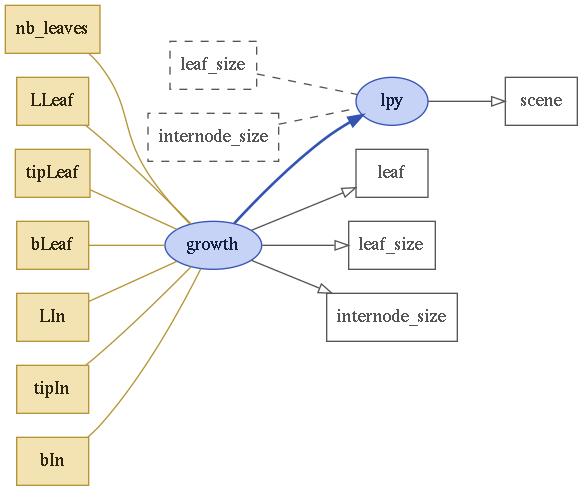

In [4]:
model = xs.Model({ 'growth': Growth, 'lpy': Lpy })
nb_leaves = 10
ds = xs.create_setup(
    model=model,
    clocks={ 
        'time': np.linspace(0, 25, 250)
    },
    input_vars={
        'growth': {
            'nb_leaves': nb_leaves,
            'LLeaf': np.linspace(4.9, 10, nb_leaves),
            'tipLeaf': np.linspace(0, 20, nb_leaves),
            'bLeaf': 1.7,
            'LIn': np.linspace(1, 5, nb_leaves),
            'tipIn': np.linspace(0.2, 20, nb_leaves),
            'bIn': 1.3     
        }
    },
    output_vars={
        'growth__leaf_size': 'time',
        'growth__internode_size': 'time'
    }
)
model.visualize(show_inputs=True, show_variables=True)

### Setup a hook to visualise simulation results at runtime

In [5]:
sw = pgljupyter.SceneWidget()

@xs.runtime_hook('run_step')
def hook(model, context, state):
    sw.set_scenes([state[('lpy', 'scene')]], scales=1/100)
sw

SceneWidget(scenes=[{'id': '44kRSfcbSTKaVwMGSRZW2oWD8', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

### Run the model and inspect results

In [6]:
ds_out = ds.xsimlab.run(model=model, hooks=[hook, ProgressBar()])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                 (leaf: 10, time: 250)
Coordinates:
  * leaf                    (leaf) object 'L0' 'L1' 'L2' 'L3' ... 'L7' 'L8' 'L9'
  * time                    (time) float64 0.0 0.1004 0.2008 ... 24.8 24.9 25.0
Data variables:
    growth__LIn             (leaf) float64 1.0 1.444 1.889 ... 4.111 4.556 5.0
    growth__LLeaf           (leaf) float64 4.9 5.467 6.033 ... 8.867 9.433 10.0
    growth__bIn             float64 1.3
    growth__bLeaf           float64 1.7
    growth__internode_size  (time, leaf) float64 0.4616 0.1969 ... 4.536 4.887
    growth__leaf_size       (time, leaf) float64 2.45 1.164 ... 9.292 9.47
    growth__nb_leaves       int64 10
    growth__tipIn           (leaf) float64 0.2 2.4 4.6 6.8 ... 15.6 17.8 20.0
    growth__tipLeaf         (leaf) float64 0.0 2.222 4.444 ... 15.56 17.78 20.0

### Plot output

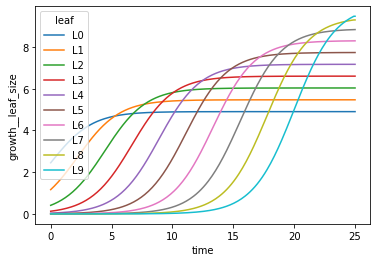

In [7]:
ds_out.growth__leaf_size.plot.line(x='time');

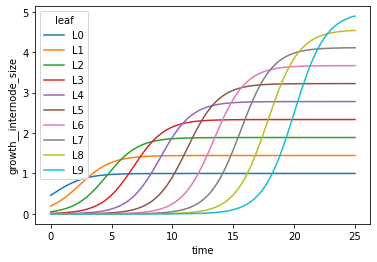

In [8]:
ds_out.growth__internode_size.plot.line(x='time');